In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

In [ ]:
# Load and preprocess the dataset
(X_train, _), (_, _) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
# Generator model
def build_generator(latent_dim):
    model = Sequential()

    model.add(Dense(256, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(28 * 28 * 1, activation='tanh'))
    model.add(Reshape((28, 28, 1)))

    return model

# Discriminator model
def build_discriminator(img_shape):
    model = Sequential()

    model.add(Flatten(input_shape=img_shape))

    model.add(Dense(1024, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(1, activation='sigmoid'))

    return model

# Combined generator and discriminator model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [ ]:
# Compile discriminator
img_shape = (28, 28, 1)
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])


In [ ]:
# Compile generator
latent_dim = 100
generator = build_generator(latent_dim)


In [ ]:
# Compile the combined model
discriminator.trainable = False
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))


1/1 [==============================] - 0s 419ms/step
Epoch 0, D Loss: 0.5312661528587341, G Loss: 0.5627034902572632


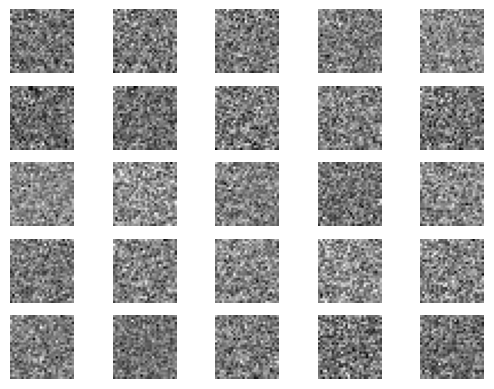

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 27ms/step
Epoch 1000, D Loss: 0.31862007081508636, G Loss: 2.589266300201416
1/1 [==============================] - 0s 23ms/step
Epoch 2000, D Loss: 0.5733377933502197, G Loss: 1.6518501043319702
1/1 [==============================] - 0s 23ms/step
Epoch 3000, D Loss: 0.5368553698062897, G Loss: 1.2213807106018066
1/1 [==============================] - 0s 39ms/step
Epoch 4000, D Loss: 0.5855322182178497, G Loss: 1.186819076538086
1/1 [==============================] - 0s 26ms/step
Epoch 5000, D Loss: 0.6180409789085388, G Loss: 1.0129282474517822


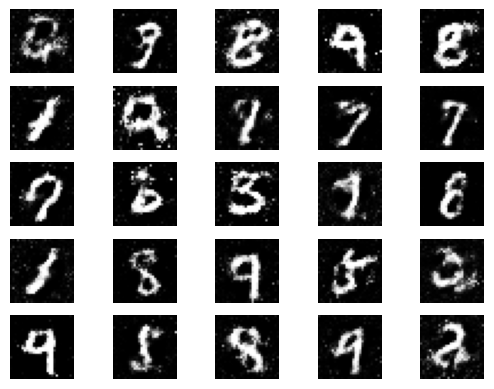

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 27ms/step
Epoch 6000, D Loss: 0.5643027722835541, G Loss: 0.9812607765197754
1/1 [==============================] - 0s 26ms/step
Epoch 7000, D Loss: 0.6544559895992279, G Loss: 0.9780280590057373
1/1 [==============================] - 0s 45ms/step
Epoch 8000, D Loss: 0.7355380952358246, G Loss: 1.0169862508773804
1/1 [==============================] - 0s 28ms/step
Epoch 9000, D Loss: 0.644491583108902, G Loss: 0.925221860408783
1/1 [==============================] - 0s 28ms/step


In [ ]:
# Training the DCGAN
# model saved in drive "generator_model_trained.h5"
epochs = 10000
batch_size = 64
half_batch = int(batch_size / 2)

for epoch in range(epochs):
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    imgs = X_train[idx]

    noise = np.random.normal(0, 1, (half_batch, latent_dim))
    gen_imgs = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    valid_y = np.array([1] * batch_size)

    g_loss = gan.train_on_batch(noise, valid_y)

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")

        # Save generated images at specified intervals
        if epoch % 5000 == 0:
            gen_imgs = 0.5 * gen_imgs + 0.5
            fig, axs = plt.subplots(5, 5)
            count = 0
            for i in range(5):
                for j in range(5):
                    axs[i, j].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                    axs[i, j].axis('off')
                    count += 1
            plt.show()


In [ ]:
from tensorflow.keras.models import load_model, save_model

# Assuming 'generator' is your already trained generator model
generator.save('generator_model_trained.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 130ms/step


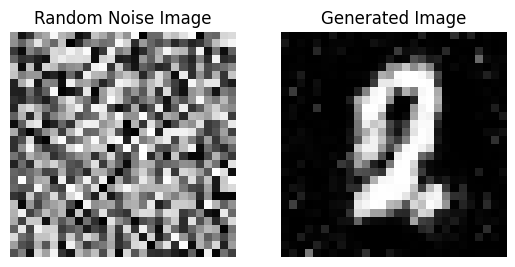

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def generate_image(generator_model, latent_dim):
    noise = np.random.normal(0, 1, (1, latent_dim))
    generated_image = generator_model.predict(noise)
    generated_image = 0.5 * generated_image + 0.5  # Rescale values to [0, 1]
    return generated_image.squeeze()

# Load the trained generator model
generator = load_model('generator_model_trained.h5')  # Replace with the actual path to your generator model

# Set latent dimension (should be the same as the one used during training)
latent_dim = 100

# Generate a random noise image
random_noise_image = np.random.uniform(0, 1, (28, 28))  # Adjust the shape as needed

# Generate and display both the random noise image and the generated image
plt.subplot(1, 2, 1)
plt.imshow(random_noise_image, cmap='gray')
plt.title('Random Noise Image')
plt.axis('off')

plt.subplot(1, 2, 2)
generated_image = generate_image(generator, latent_dim)
plt.imshow(generated_image, cmap='gray')
plt.title('Generated Image')
plt.axis('off')

# Save the generated image
# image.save_img('generated_image.png', generated_image)
# print("Generated image saved as 'generated_image.png'")
plt.show()
